In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import folium
import random
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster

In [2]:
# Read the temperature data.
# The data was processed from this Kaggle dataset: 
# https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
cities_data = pd.read_csv("./data/cities_temperatures.csv")

In [3]:
cities_data.drop(columns=['Unnamed: 0'], inplace=True)
cities_data.head()

,City,Country,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Århus,Denmark,57.05N,10.33E,1.369833,1.414583,3.345708,7.315542,12.062500,15.201042,17.696667,17.431875,13.706913,8.922130,4.982000,1.747000
1,Çorlu,Turkey,40.99N,27.69E,4.729375,5.218375,7.799125,11.918708,17.008583,21.495083,23.994875,24.197000,20.062652,15.589348,10.766739,6.623043
2,Çorum,Turkey,40.99N,34.08E,-0.180833,1.223792,5.131625,9.815667,14.493875,18.462583,21.516833,21.559042,17.236652,11.952478,5.659043,1.479391
3,Öskemen,Kazakhstan,50.63N,82.39E,-15.803875,-13.603583,-6.613833,4.494750,12.461000,17.497875,19.035000,17.032417,11.092870,4.077609,-5.639130,-12.985652
4,Ürümqi,China,44.20N,87.20E,-14.809458,-10.467917,-0.515792,10.890625,17.701542,22.674750,24.160917,22.790417,17.002478,8.244478,-1.460522,-11.025217


In [4]:
# Check the shape
cities_data.shape

(3510, 16)

In [5]:
# The dataset contains different cities with the same coordinates and temperatures. So, because we only care about the 
# position, we will only keep one city from those (which also makes the computations faster)
cities_data_normalized = cities_data.drop_duplicates(subset=['Jan', 'Feb', 'Mar', 'Apr', 'May']).copy()

In [6]:
# The geographic problem with regions in the southern hemisphere is that their winter is during the May-August period
# So, to avoid having different climate regions with the same monthly temperatures, but different seasons, we will have
# to rotate the temperatures by six months

# You can see that the temperatures during Jun-Aug are colder than during Dec-Feb
cities_data_normalized[cities_data_normalized.Latitude.str.contains('S')]

,City,Country,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
33,Adelaide,Australia,34.56S,138.16E,22.642500,22.745667,20.415375,17.205500,14.219500,11.718917,10.899625,11.619333,13.627043,15.772696,18.995435,20.587870
36,Adiwerna,Indonesia,7.23S,109.46E,26.443167,26.451167,26.725333,26.939958,27.246125,26.691792,26.124333,26.157833,26.812348,27.276087,27.222174,26.684478
63,Alagoinhas,Brazil,12.05S,37.81W,27.161083,27.406875,27.568875,26.890042,25.995250,24.932458,24.281917,24.324458,25.185130,26.059522,26.749652,26.996000
68,Alberton,South Africa,26.52S,28.66E,20.009750,19.996292,18.653458,15.482333,12.084583,9.240250,9.049292,12.056583,16.116565,17.883435,18.828217,19.572957
70,Albury,Australia,36.17S,147.18E,22.147042,21.621958,18.450500,14.010958,10.493542,7.973417,7.040458,8.117750,10.620435,13.379870,16.971870,19.336478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,Uruguaiana,Brazil,29.74S,57.23W,26.729042,25.621958,24.298167,20.639833,17.059583,14.754833,13.984333,16.173208,17.767478,20.646130,23.241739,25.451565
3296,Vitória Da Conquista,Brazil,15.27S,40.83W,24.082875,24.242042,24.056542,23.010958,21.533750,20.028083,19.476917,20.003375,21.521652,22.802609,23.316957,23.788696
3350,Windhoek,Namibia,23.31S,16.60E,23.720583,23.408667,22.939958,20.666000,17.765292,14.998542,14.956000,16.698333,19.775043,22.002304,23.379870,24.092783
3360,Worcester,South Africa,32.95S,20.11E,22.896875,23.020833,21.201333,17.215833,13.578667,10.500875,10.075875,10.954125,13.574783,16.508783,19.118826,21.524435


In [7]:
# We also need to take into account that cities with the same name exist in the dataset

cities_data[cities_data['City'] == 'Worcester']

,City,Country,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
3360,Worcester,South Africa,32.95S,20.11E,22.896875,23.020833,21.201333,17.215833,13.578667,10.500875,10.075875,10.954125,13.574783,16.508783,19.118826,21.524435
3361,Worcester,United Kingdom,52.24N,2.63W,4.367417,4.724667,6.565000,8.524250,11.859333,14.578208,16.556667,16.342708,13.736043,10.192391,7.027391,4.189304
3362,Worcester,United States,42.59N,72.00W,-4.874000,-3.541333,1.277750,7.652167,13.720125,18.869625,21.511500,20.562583,16.171417,9.518000,4.140609,-1.667783


In [8]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Get the cities in the southern hemisphere
southern = cities_data_normalized[cities_data_normalized.Latitude.str.contains('S')]

# Rotate by 6 months
for index in southern.index:
    for idx, month in enumerate(months):
        cities_data_normalized.loc[index, month] = cities_data.loc[index, months[(idx + 6) % 12]]

# Now it looks normal
cities_data_normalized[cities_data_normalized.Latitude.str.contains('S')]

,City,Country,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
33,Adelaide,Australia,34.56S,138.16E,10.899625,11.619333,13.627043,15.772696,18.995435,20.587870,22.642500,22.745667,20.415375,17.205500,14.219500,11.718917
36,Adiwerna,Indonesia,7.23S,109.46E,26.124333,26.157833,26.812348,27.276087,27.222174,26.684478,26.443167,26.451167,26.725333,26.939958,27.246125,26.691792
63,Alagoinhas,Brazil,12.05S,37.81W,24.281917,24.324458,25.185130,26.059522,26.749652,26.996000,27.161083,27.406875,27.568875,26.890042,25.995250,24.932458
68,Alberton,South Africa,26.52S,28.66E,9.049292,12.056583,16.116565,17.883435,18.828217,19.572957,20.009750,19.996292,18.653458,15.482333,12.084583,9.240250
70,Albury,Australia,36.17S,147.18E,7.040458,8.117750,10.620435,13.379870,16.971870,19.336478,22.147042,21.621958,18.450500,14.010958,10.493542,7.973417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,Uruguaiana,Brazil,29.74S,57.23W,13.984333,16.173208,17.767478,20.646130,23.241739,25.451565,26.729042,25.621958,24.298167,20.639833,17.059583,14.754833
3296,Vitória Da Conquista,Brazil,15.27S,40.83W,19.476917,20.003375,21.521652,22.802609,23.316957,23.788696,24.082875,24.242042,24.056542,23.010958,21.533750,20.028083
3350,Windhoek,Namibia,23.31S,16.60E,14.956000,16.698333,19.775043,22.002304,23.379870,24.092783,23.720583,23.408667,22.939958,20.666000,17.765292,14.998542
3360,Worcester,South Africa,32.95S,20.11E,10.075875,10.954125,13.574783,16.508783,19.118826,21.524435,22.896875,23.020833,21.201333,17.215833,13.578667,10.500875


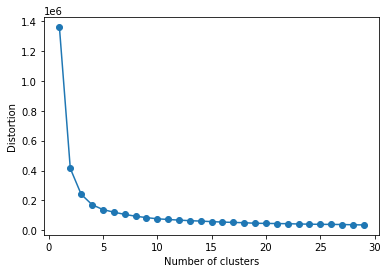

In [9]:
# I will use KMeans to cluster the climate regions
# First, to find the optimal number of clusters

# Calculate distortion for a range of number of cluster
distortions = []
dropped_columns = ['City', 'Country', 'Latitude', 'Longitude']
for i in range(1, 30):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(cities_data_normalized.drop(dropped_columns, axis=1))
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 30), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [10]:
# 13 seems like an ok number, also considering the number of climates in the Köppen climate classification

km = KMeans(
    n_clusters=13, init='random',
    n_init=20, max_iter=500, 
    tol=1e-04, random_state=0,
    algorithm='elkan'
)

# Add the cluster index to the table
pred = km.fit_predict(cities_data_normalized.drop(dropped_columns, axis=1))
cities_data_normalized['pred'] = pred
cities_data_normalized

,City,Country,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,pred
0,Århus,Denmark,57.05N,10.33E,1.369833,1.414583,3.345708,7.315542,12.062500,15.201042,17.696667,17.431875,13.706913,8.922130,4.982000,1.747000,4
1,Çorlu,Turkey,40.99N,27.69E,4.729375,5.218375,7.799125,11.918708,17.008583,21.495083,23.994875,24.197000,20.062652,15.589348,10.766739,6.623043,2
2,Çorum,Turkey,40.99N,34.08E,-0.180833,1.223792,5.131625,9.815667,14.493875,18.462583,21.516833,21.559042,17.236652,11.952478,5.659043,1.479391,6
3,Öskemen,Kazakhstan,50.63N,82.39E,-15.803875,-13.603583,-6.613833,4.494750,12.461000,17.497875,19.035000,17.032417,11.092870,4.077609,-5.639130,-12.985652,7
4,Ürümqi,China,44.20N,87.20E,-14.809458,-10.467917,-0.515792,10.890625,17.701542,22.674750,24.160917,22.790417,17.002478,8.244478,-1.460522,-11.025217,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,Zhytomyr,Ukraine,50.63N,29.15E,-3.466458,-2.955208,1.594208,8.768000,14.692792,18.022208,20.195708,19.015958,13.492348,7.658130,2.288609,-2.800565,4
3500,Ziguinchor,Senegal,12.05N,16.44W,24.606375,25.389875,26.061292,26.153208,27.410250,28.301458,27.672000,27.256875,27.366043,27.977696,27.405739,25.352652,9
3501,Zinder,Niger,13.66N,9.08E,22.279250,25.638583,30.053750,33.594458,34.057417,32.378458,29.346833,27.899083,29.325522,30.185043,27.156609,23.172826,0
3504,Zonguldak,Turkey,40.99N,31.95E,1.571125,2.770833,6.095542,10.479042,15.172833,19.205875,22.040083,22.018708,17.779696,13.035478,7.501913,3.455609,6


In [21]:
# Create a world map and place the points with different colors based on the cluster

world_map= folium.Map()
geolocator = Nominatim(user_agent="Temperatures")

# Give each cluster its color
city_color = [
    "red",
    "orange",
    "indigo",
    "green",
    "blue",
    "yellow",
    "violet",
    "purple",
    "pink",
    "silver",
    "gold",
    "lightgreen",
    "brown",
    "black",
    "gray",
]

# Add each data row to the map as a point
for i in range(len(cities_data_normalized)):
        lat = float(cities_data_normalized.iloc[i]['Latitude'][:-1])
        long = float(cities_data_normalized.iloc[i]['Longitude'][:-1])
        if cities_data_normalized.iloc[i]['Latitude'][-1] == 'S':
            lat *= (-1)
        if cities_data_normalized.iloc[i]['Longitude'][-1] == 'W':
            long *= (-1)
        radius = 30000
        folium.Circle(location = [lat, long], 
                      popup=cities_data_normalized.iloc[i]['City'],
                      radius=radius,
                      color=city_color[cities_data_normalized.iloc[i]['pred']],
                      fill=True, 
                      fill_color=city_color[cities_data_normalized.iloc[i]['pred']]
                     ).add_to(world_map)

# Display the map
world_map

In [12]:
# Save the map
world_map.save("climates-13.html")

# The result seems fine and close to the actual climate classification. It is amazing that this can be done only using
# temperatures only, ommiting other climate (rainfall, humidity, winds, events) and geographical 
# factors (landforms, vegetation, fauna, etc) ^^ 